In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import jax.numpy as jnp
from jax import jit, grad, jacobian, lax, vmap

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import time
import scipy.optimize as so

In [4]:
n = 3
dt = 1e-1
numsteps = 100
tvec = dt*jnp.arange(numsteps)
rho = 1e6

h0 = np.load('workingh0.npz')['h0']
m = jnp.array([[1.0,1.5,-1.0],[1.5,1.0,0.0],[-1.0,0.0,1.0]])

# h0 = jnp.array(np.diag(np.sort(np.pi*np.random.uniform(size=n))))
# mraw = np.random.normal(size=n**2).reshape((n,n)) + 1j*np.random.normal(size=n**2).reshape((n,n))
# m = jnp.array(0.5*(mraw + mraw.conj().T))

print(jnp.mean(jnp.abs(h0 - h0.T)))
print(jnp.mean(jnp.abs(m - m.conj().T)))

0.0
0.0


In [5]:
# (d/dx) \exp(-1j*dt*(h0 + x m))
# where you pass in the eigenvectors and eigenvalues of (h0 + x m)
def firstderiv(evecs, evals):
    amat = evecs.conj().T @ (-1j*dt*m) @ evecs
    dvec = -1j*dt*evals
    dvec1, dvec2 = jnp.meshgrid(dvec, dvec)
    mask = jnp.ones((n,n)) - jnp.eye(n)
    numer = jnp.exp(dvec1) - jnp.exp(dvec2)
    denom = (dvec1 - dvec2)*mask + jnp.eye(n)
    derivmat = mask*numer/denom + jnp.diag(jnp.exp(dvec))
    qmat = evecs @ (amat * derivmat) @ evecs.conj().T
    return qmat

In [6]:
mask = jnp.ones((n,n)) - jnp.eye(n)

# (d^2/dx^2) \exp(-1j*dt*(h0 + x m))
# where you pass in the eigenvectors and eigenvalues of (h0 + x m)
def secondderiv(evecs, rawevals):
    evals = (-1j*dt)*rawevals
    a = (evecs.conj().T @ m @ evecs) * (-1j*dt)
    expevals = jnp.exp(evals)
    evals1, evals2 = jnp.meshgrid(evals, evals, indexing='ij')
    expevals1, expevals2 = jnp.meshgrid(expevals, expevals, indexing='ij')
    # first D_{ii}=D_{kk} term
    diagterm1 = expevals1*jnp.diag(jnp.diag(a*a))
    # second D_{ii}=D_{kk} term
    numer1 = -expevals1 + evals1*expevals1 - evals2*expevals1 + expevals2
    denom1 = (evals1-evals2)**2 + jnp.eye(n)
    maska = mask * a
    diagterm2 = jnp.eye(n) * 2*((numer1/denom1 * maska) @ maska)
    # first D_{ii}!=D_{kk} term
    frac1 = numer1/denom1 * mask
    term1 = frac1*2*(jnp.diag(a)*a).conj().T
    # second D_{ii}!=D_{kk} term
    numer2 = -expevals1 + evals1*expevals2 - evals2*expevals2 + expevals2
    denom2 = (evals1-evals2)**2 + jnp.eye(n)
    frac2 = numer2/denom2 * mask
    term2 = frac2*2*(a*jnp.diag(a))
    # third D_{ii}!=D_{kk} term
    matij = mask*(1.0/((evals1-evals2) + jnp.eye(n)))
    matind1a = (expevals1 * matij) * a
    matind2a = (expevals2 * matij) * a
    term3 = 2*mask*((matind2a) @ (matij*a))
    term3 -= 2*matij*( matind1a @ maska )
    term3 -= 2*matij*( maska @ matind2a ) 
    # put it all together
    # udagru stands for "U^{\dagger} R U"
    udagru = term1 - term2 - term3 + diagterm1 + diagterm2
    return evecs @ udagru @ evecs.conj().T

In [7]:
def gradal(l,expderiv,a,matexp):
    ea = expderiv @ a
    gradvecs = [(l==0)*ea + (l>0)*jnp.zeros(n, dtype=jnp.complex128)]
    for k in range(1,numsteps):
        thisvec = (k<l)*jnp.zeros(n, dtype=jnp.complex128)
        thisvec += (k==l)*ea
        thisvec += (k>l)*(matexp[k] @ gradvecs[k-1])
        gradvecs.append( thisvec )
    
    # zeroblock = jnp.zeros((l, n), dtype=jnp.complex128)
    return jnp.stack(gradvecs, axis=0)

In [8]:
def onematexp(evecs,expevals):
    return evecs @ jnp.diag(expevals) @ evecs.conj().T

In [9]:
manyeigh = vmap(jnp.linalg.eigh)
vfd = vmap(firstderiv, in_axes=(0,0))
vsd = vmap(secondderiv, in_axes=(0,0))
vgradal = vmap(gradal, in_axes=(0,0,0,None))
vonematexp = vmap(onematexp)

In [356]:
numparams = 128
def fmodelraw(theta, t):
    freqvec = jnp.arange(numparams//2)
    return theta.T @ jnp.concatenate([jnp.cos(freqvec*t), jnp.sin(freqvec)*t])

In [357]:
# # PARAMETERS THAT DEFINE NEURAL NET CONTROL (FIELD STRENGTH)
# layerwidths = [1, 16, 16, 1]
# nlayers = len(layerwidths)-1
# numparams = 0
# numweights = 0
# for j in range(nlayers):
#     numparams += layerwidths[j]*layerwidths[j+1] + layerwidths[j+1]
#     numweights += layerwidths[j]*layerwidths[j+1]

# print("number of neural network parameters = " + str(numparams))

# def fmodelraw(theta, t):
#     filt = []
#     for j in range(nlayers):
#         if j==0:
#             si = 0
#             ei = layerwidths[0]*layerwidths[1]
#         else:
#             si += layerwidths[j-1]*layerwidths[j]
#             ei += layerwidths[j]*layerwidths[j+1]
#         filt.append( theta[si:ei].reshape((layerwidths[j],layerwidths[j+1])) )

#     bias = []
#     for j in range(nlayers):
#         if j==0:
#             si += layerwidths[nlayers-1]*layerwidths[nlayers]
#             ei += layerwidths[1]
#         else:
#             si += layerwidths[j]
#             ei += layerwidths[j+1]
#         bias.append( theta[si:ei] )
    
#     f = jax.nn.softplus( t * filt[0] + bias[0] )
#     for j in range(nlayers-2):
#         f = jax.nn.softplus( f @ filt[j+1] + bias[j+1] )
    
#     f = f @ filt[nlayers-1] + bias[nlayers-1]
#     return f[0,0]

In [358]:
# # XAVIER WEIGHT INITIALIZATION
# def xavier():
#     params = []
#     for i in range(nlayers):
#         a = 1.0/np.sqrt(layerwidths[i])
#         params.append( np.random.uniform(size=layerwidths[i]*layerwidths[i+1], low=-a, high=a) )
#     params.append( np.zeros(numparams-numweights) )
#     return np.concatenate(params)

In [359]:
fmodel = vmap(fmodelraw, in_axes=(None,0))

gradfraw = jacobian(fmodelraw)
gradf = vmap(gradfraw, in_axes=(None,0))

hessfraw = jacobian(gradfraw)
hessf = vmap(hessfraw, in_axes=(None,0))

In [360]:
# given initial condition and forcing f, return trajectory a
def propSchro(theta, a0):
    manyhams = jnp.expand_dims(h0,0) + jnp.expand_dims(fmodel(theta, tvec),(1,2))*jnp.expand_dims(m,0)
    allevals, allevecs = manyeigh(manyhams)
    expevals = jnp.exp(-1j*dt*allevals)
    matexp = vonematexp(allevecs,expevals)
    
    a = jnp.concatenate([jnp.expand_dims(a0,0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def amatbody(k, am):
        return am.at[k+1].set( matexp[k] @ am[k] )
    
    # forward trajectory
    a = lax.fori_loop(0, numsteps, amatbody, a)
    return a

# given forcing f, IC a0, FC alpha, return cost
def cost(theta, a0, alpha):
    a = propSchro(theta, a0)
    resid = a[-1] - alpha
    pen = jnp.real(jnp.sum(resid * resid.conj()))
    return 0.5*jnp.sum(fmodel(theta, tvec)**2) + 0.5*rho*pen

In [361]:
# adjoint method
def adjgrad(theta, a0, alpha):
    f = fmodel(theta, tvec)
    gf = gradf(theta, tvec)
    manyhams = jnp.expand_dims(h0,0) + jnp.expand_dims(f,(1,2))*jnp.expand_dims(m,0)
    allevals, allevecs = manyeigh(manyhams)
    expevals = jnp.exp(-1j*dt*allevals)
    matexp = vonematexp(allevecs,expevals)
    
    a = jnp.concatenate([jnp.expand_dims(a0,0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def amatbody(k, am):
        return am.at[k+1].set( matexp[k] @ am[k] )
    
    # forward trajectory
    a = lax.fori_loop(0, numsteps, amatbody, a)
    
    # initialize lambda
    resid = a[-1] - alpha
    
    # we are storing "lambda conjugate" throughout this calculation
    alllamb = jnp.concatenate([jnp.expand_dims(rho*resid.conj(),0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def lambbody(i, al):
        k = (numsteps-1) - i
        return al.at[i+1].set( al[i] @ matexp[k] )
    
    # backward trajectory
    alllamb = lax.fori_loop(0, numsteps, lambbody, alllamb)
    alllamb = jnp.flipud(alllamb)
    
    # first critical calculation
    allexpderivs = vfd(allevecs, allevals)
    
    # output gradient we want
    ourgrad = jnp.einsum('ai,aij,al,aj->l',alllamb[1:],allexpderivs,gf,a[:-1])
    thegrad = f @ gf + jnp.real(ourgrad)
    
    return thegrad

In [362]:
# second-order adjoint method
def adjhess(theta, a0, alpha):
    f = fmodel(theta, tvec)
    gf = gradf(theta, tvec)
    hf = hessf(theta, tvec)
    manyhams = jnp.expand_dims(h0,0) + jnp.expand_dims(f,(1,2))*jnp.expand_dims(m,0)
    allevals, allevecs = manyeigh(manyhams)
    expevals = jnp.exp(-1j*dt*allevals)
    matexp = vonematexp(allevecs,expevals)

    a = jnp.concatenate([jnp.expand_dims(a0,0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def amatbody(k, am):
        return am.at[k+1].set( matexp[k] @ am[k] )
    
    # forward trajectory
    a = lax.fori_loop(0, numsteps, amatbody, a)
    
    # initialize lambda
    resid = a[-1] - alpha
    
    # we are storing "lambda conjugate" throughout this calculation
    alllamb = jnp.concatenate([jnp.expand_dims(rho*resid.conj(),0), jnp.zeros((numsteps, n), dtype=jnp.complex128)])
    def lambbody(i, al):
        k = (numsteps-1) - i
        return al.at[i+1].set( al[i] @ matexp[k] )
    
    # backward trajectory
    alllamb = lax.fori_loop(0, numsteps, lambbody, alllamb)
    alllamb = jnp.flipud(alllamb)
    
    # first critical calculation
    allexpderivs = vfd(allevecs, allevals)
    
    # compute gradient of a w.r.t. f
    # grada tensor stores the gradient of the n-dimensional vector a[k] with respect to f[l]
    lvec = jnp.arange(numsteps,dtype=jnp.int16)
    grada = vgradal(lvec, allexpderivs, a[:-1], matexp)
    grada = jnp.transpose(grada,(1,0,2))
    grada = jnp.einsum('ijk,jl->ilk',grada,gf)
    
    # create and propagate mu
    # as before, let us store and propagate "mu conjugate"
    allmu0 = rho*grada[numsteps-1,:,:].conj()
    allmu = jnp.concatenate([jnp.expand_dims(allmu0,0),
                             jnp.zeros((numsteps, numparams, n), dtype=jnp.complex128)])
    # allprevmu2 = jnp.flipud(jnp.outer(jnp.ones(n),jnp.eye(numsteps)).T.reshape((numsteps,numsteps,n)))
    def mubody(kk, amu):
        k = (numsteps-1) - kk
        prevmu1 = amu[kk] @ matexp[k]
        prevmu2 = jnp.outer(gf[k],alllamb[k+1].T @ allexpderivs[k])
        return amu.at[kk+1].set( prevmu1+prevmu2 )

    # backward trajectory
    allmu = lax.fori_loop(0, numsteps, mubody, allmu)
    allmu = jnp.flipud(allmu)
        
    # second critical calculation
    allexpderivs2 = vsd(allevecs, allevals)
    
    # compute Hessian
    gradapad = jnp.concatenate([jnp.zeros((1,numparams,n),dtype=jnp.complex128), grada[:-1,:,:]])
    # j -> numsteps
    # l -> numparams
    # k -> n
    term1 = jnp.einsum('jlk,jka,jm,ja->lm',allmu[1:],allexpderivs,gf,a[:-1])
    term2a = jnp.einsum('jk,jka,jlm,ja->lm',alllamb[1:],allexpderivs,hf,a[:-1])
    term2b = jnp.einsum('jk,jka,jl,jm,ja->lm',alllamb[1:],allexpderivs2,gf,gf,a[:-1])
    term3 = jnp.einsum('jk,jka,jm,jla->lm',alllamb[1:],allexpderivs,gf,gradapad)
    pcc = term1 + term2a + term2b + term3
    hcc = jnp.einsum('ai,aj->ij',gf,gf) + jnp.einsum('a,aij->ij',f,hf)
    thehess = hcc + jnp.real(pcc)
    
    return thehess

In [363]:
jcost = jit(cost)
jadjgrad = jit(adjgrad)
jadjhess = jit(adjhess)

In [364]:
mya0 = jnp.eye(n)[0]
myalpha = jnp.eye(n)[n-1]

In [365]:
thetatest = jnp.array(0.01*np.random.normal(size=numparams))
mycost = jcost(thetatest, mya0, myalpha)
mygrad = jadjgrad(thetatest, mya0, myalpha)
myhess = jadjhess(thetatest, mya0, myalpha)

In [366]:
def obj(x):
    jx = jnp.array(x)
    return jcost(jx,mya0,myalpha).item()

In [367]:
def gradobj(x):
    jx = jnp.array(x)
    return np.array(jadjgrad(jx,mya0,myalpha))

In [368]:
def hessobj(x):
    jx = jnp.array(x)
    return np.array(jadjhess(jx,mya0,myalpha))

In [382]:
thetatest = jnp.array(0.01*np.random.normal(size=numparams))
print(obj(thetatest))

941682.5867666265


In [387]:
np.savez('Feb16resultsGreen.npz',thetatest=thetatest,xstarx=xstar.x)

In [383]:
start = time.time()
xstar = so.minimize(obj, x0=thetatest, method='trust-constr', jac=gradobj, hess=hessobj,
                    options={'gtol':1e-16,'xtol':1e-16,'verbose':2,'maxiter':10000})
end = time.time()
print(end-start)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +9.4168e+05 | 1.00e+00 | 4.39e+06 | 0.00e+00 |
|   2   |   2   |   2   | +9.4168e+05 | 5.00e-01 | 4.39e+06 | 0.00e+00 |
|   3   |   3   |   4   | +9.4168e+05 | 2.50e-01 | 4.39e+06 | 0.00e+00 |
|   4   |   4   |   6   | +4.6860e+05 | 2.50e-01 | 2.52e+06 | 0.00e+00 |
|   5   |   5   |   9   | +2.6614e+05 | 1.75e+00 | 1.64e+06 | 0.00e+00 |
|   6   |   6   |  13   | +2.6614e+05 | 8.22e-01 | 1.64e+06 | 0.00e+00 |
|   7   |   7   |  16   | +2.6614e+05 | 4.11e-01 | 1.64e+06 | 0.00e+00 |
|   8   |   8   |  19   | +1.1504e+05 | 8.22e-01 | 5.19e+06 | 0.00e+00 |
|   9   |   9   |  22   | +1.1504e+05 | 4.11e-01 | 5.19e+06 | 0.00e+00 |
|  10   |  10   |  25   | +1.1504e+05 | 1.70e-01 | 5.19e+06 | 0.00e+00 |
|  11   |  11   |  28   | +7.9280e+04 | 1.70e-01 | 3.67e+06 | 0.00e+00 |
|  12   |  12   |  33   | +6.8415e+04 | 1.70e-01 | 

In [384]:
xstar.execution_time

7.082132339477539

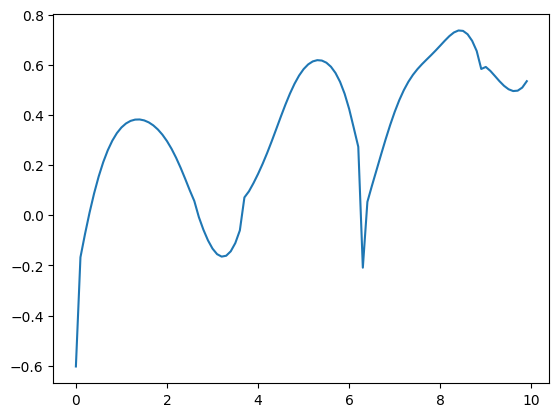

In [385]:
plt.plot(np.array(tvec), np.array(fmodel(jnp.array(xstar.x), tvec)))
plt.show()

In [386]:
jnp.mean(jnp.abs(propSchro(jnp.array(xstar.x), mya0)[-1] - myalpha))

Array(9.4436698e-06, dtype=float64)